<a href="https://colab.research.google.com/github/NidentalEgor/DigitRecognizerKaggle/blob/master/digit_recognizer_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
from keras.datasets import mnist
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from tensorflow.python.client import device_lib

Using TensorFlow backend.


In [0]:
def read_dataset():
  #(X_train, y_train), (X_test, y_test) = mnist.load_data()
  #print("downloaded")
  #return X_train, y_train, X_test

  train_data_file = F"/content/gdrive/My Drive/Colab Notebooks/DigitRecognizerKaggle/Input/train.csv"
  test_data_file = F"/content/gdrive/My Drive/Colab Notebooks/DigitRecognizerKaggle/Input/test.csv"
  print("loaded")

  train_data = pd.read_csv(train_data_file)
  test_data = pd.read_csv(test_data_file)

  Y_train = train_data.iloc[:,0].to_numpy()
  Y_train_result = tf.keras.utils.to_categorical(Y_train.reshape(-1,1))
  print(Y_train_result.shape)
  X_train = train_data.iloc[:,1:].to_numpy() / 255.0 # normalization
  X_train_result = X_train.reshape(-1,28,28,1)
  print(X_train_result.shape)

  X_test = test_data.to_numpy() / 255.0 # normalization
  X_test_result = X_test.reshape(-1,28,28,1)
  print(X_test_result.shape)
  
  return X_train_result, Y_train_result, X_test_result

In [0]:
def create_model(show_summary = False):
  if False:
    model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(64, 3, activation='relu', input_shape=(28,28,1),padding="same"),
      tf.keras.layers.MaxPool2D(strides=2),
      
      
      tf.keras.layers.Conv2D(128, 3, activation='relu',padding="same"),
      tf.keras.layers.MaxPool2D(strides=2),
      
      tf.keras.layers.Dropout(0.2),
          
      tf.keras.layers.Conv2D(256, 3, activation='relu',padding="same"),
      tf.keras.layers.MaxPool2D(strides=2),
      
      tf.keras.layers.Conv2D(256, 3, activation='relu',padding="same"),
      tf.keras.layers.MaxPool2D(strides=2),
          
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(100,kernel_regularizer=tf.keras.regularizers.l2(0.01), activation='relu'),
      
      tf.keras.layers.Dense(50,kernel_regularizer=tf.keras.regularizers.l2(0.01), activation='relu'),
          
      tf.keras.layers.Dense(10, kernel_regularizer=tf.keras.regularizers.l2(0.01) ,activation='softmax')
  ])
  else:
    model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(64, 3, activation='relu', input_shape=(28,28,1),padding="same"),
      tf.keras.layers.MaxPool2D(strides=2),
      
      
      tf.keras.layers.Conv2D(128, 3, activation='relu',padding="same"),
      tf.keras.layers.MaxPool2D(strides=2),
      
      tf.keras.layers.Dropout(0.2),
          
      tf.keras.layers.Conv2D(256, 3, activation='relu',padding="same"),
      tf.keras.layers.MaxPool2D(strides=2),
      
      tf.keras.layers.Conv2D(256, 3, activation='relu',padding="same"),
      tf.keras.layers.MaxPool2D(strides=2),
          
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(100,kernel_regularizer=tf.keras.regularizers.l2(0.1), activation='relu'),
      
      tf.keras.layers.BatchNormalization(),

      tf.keras.layers.Dense(50,kernel_regularizer=tf.keras.regularizers.l2(0.1), activation='relu'),

      tf.keras.layers.BatchNormalization(),

      tf.keras.layers.Dense(25,kernel_regularizer=tf.keras.regularizers.l2(0.1), activation='relu'),
          
      tf.keras.layers.BatchNormalization(),

      tf.keras.layers.Dense(10, kernel_regularizer=tf.keras.regularizers.l2(0.1) ,activation='softmax')
  ])

  if(show_summary == True):
    model.summary()

  return model

In [0]:
def show_plot(result):
  plt.plot(result['accuracy'], label='train')
  plt.plot(result['val_accuracy'], label='valid')
  plt.legend(loc='upper left')
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.show()
  plt.plot(result['loss'], label='train')
  plt.plot(result['val_loss'], label='test')
  plt.legend(loc='upper right')
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.show()

In [0]:
def train_model(model, X_train, Y_train, batch_size=2000, epoch_number=60):
  model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])
  ln_fc = lambda x: 1e-3 * 0.985 ** x
  lrng_rt = tf.keras.callbacks.LearningRateScheduler(ln_fc)
  result = model.fit(x=X_train,y=Y_train,batch_size=batch_size,epochs=epoch_number,callbacks=[lrng_rt],
                     verbose=1,shuffle=False,initial_epoch=0,validation_split=0.2)

  show_plot(result.history)

  return model

def train_model_with_augmentation(model, X_train, Y_train, batch_size=1024, epoch_number=2):
  model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
  datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=40, zoom_range=0.2, validation_split=0.2) # Create Data Augmentation (DA) Iterator
  datagen.fit(X_train) # Our DA Iterator is trained with the image data, to calculate internal statistics
  ln_fc = lambda x: 1e-3 * 0.945 ** x # Let's add callbacks, which adjust learning rate
  lrng_rt = tf.keras.callbacks.LearningRateScheduler(ln_fc)
  # Fit our CNN-model using the DA Iterator using Flow-method, which feeds batches of augmented data:
#  result = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
#                              steps_per_epoch=len(X_train)/batch_size,verbose = 1,epochs=epoch_number,callbacks=[lrng_rt])

  history = dict()
  history["loss"] = list()
  history["accuracy"] = list()
  history["val_loss"] = list()
  history["val_accuracy"] = list()
  for e in range(epoch_number):
      print('Epoch', e)
      batches = 0
      for x_batch, y_batch in datagen.flow(X_train, Y_train, batch_size=batch_size):
          print('Batch', batches+1, '/', math.ceil(len(X_train) / batch_size))
          hist = model.fit(x=X_train,y=Y_train,batch_size=batch_size,verbose=1,validation_split=0.2).history
          history["loss"].append(hist["loss"][0])
          history["accuracy"].append(hist["accuracy"][0])
          history["val_loss"].append(hist["val_loss"][0])
          history["val_accuracy"].append(hist["val_accuracy"][0])
          batches += 1
          if batches >= len(X_train) / batch_size:
              print()
              break

  show_plot(history)

  return model

In [0]:
def predict_and_save_result(model, X_test, file_name):
  test_labels = np.argmax(model.predict(X_test), axis=-1)
  arr = [x for x in range(1,len(test_labels)+1)]
  label = pd.DataFrame(arr,columns = ["ImageId"])
  label["Label"] = pd.DataFrame(test_labels)
  result_file_path = F"/content/gdrive/My Drive/Colab Notebooks/DigitRecognizerKaggle/Result/"
  label.to_csv(result_file_path+file_name,header=True,index = False)

loaded
(42000, 10)
(42000, 28, 28, 1)
(28000, 28, 28, 1)
Epoch 0
Batch 1 / 42
33/33 [==============================] - 2s 52ms/step - loss: 20.4082 - accuracy: 0.8298 - val_loss: 16.3526 - val_accuracy: 0.1179
Batch 2 / 42
33/33 [==============================] - 1s 45ms/step - loss: 10.8489 - accuracy: 0.9704 - val_loss: 9.7919 - val_accuracy: 0.0955
Batch 3 / 42
33/33 [==============================] - 2s 46ms/step - loss: 5.9190 - accuracy: 0.9830 - val_loss: 6.4321 - val_accuracy: 0.0955
Batch 4 / 42
33/33 [==============================] - 1s 45ms/step - loss: 3.4117 - accuracy: 0.9884 - val_loss: 4.7075 - val_accuracy: 0.0955
Batch 5 / 42
33/33 [==============================] - 1s 45ms/step - loss: 2.1225 - accuracy: 0.9913 - val_loss: 3.8046 - val_accuracy: 0.0955
Batch 6 / 42
33/33 [==============================] - 1s 45ms/step - loss: 1.4358 - accuracy: 0.9935 - val_loss: 3.3107 - val_accuracy: 0.0955
Batch 7 / 42
33/33 [==============================] - 1s 45ms/step - loss:

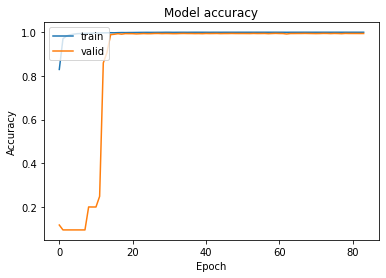

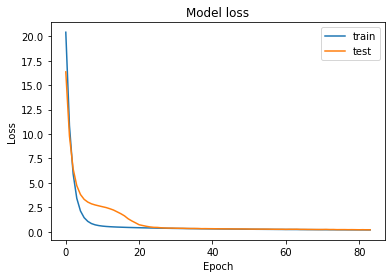

In [53]:
#print(device_lib.list_local_devices())
X_train, Y_train, X_test = read_dataset()
model = create_model()
model = train_model_with_augmentation(model, X_train, Y_train)

In [0]:
predict_and_save_result(model, X_test, "result_5.csv")